# Gaussian Process Tutorial Part 1: Introduction

In this first notebook, we start with a high-level introduction and then implement our Gaussian Process regression class.

In [1]:
# Imports
%matplotlib inline

import sys
import numpy as np
import pandas as pd
import scipy
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, cdist, squareform
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib import cm
from random import sample 
import pdb

sns.set_style('darkgrid')
np.random.seed(42)
#

REGRESSION PROBLEMS
Suppose you have the task to make a predict for the value of y at the location marked by the red vertical line in the picture below.

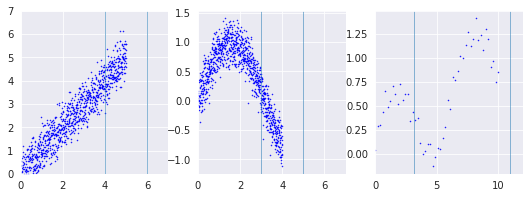

In [107]:
def f1(x): 
    return x + 0.5*np.random.randn(len(x))

def f2(x): 
    return np.sin(x) + 0.2*np.random.randn(len(x))

def f3(x):     
    return 0.1*x+0.5*np.sin(x)+ 0.1*np.random.randn(len(x))


X1 = np.linspace(0, 5, 1000)
X2 = np.linspace(0, 4, 1000)
X3 = np.linspace(0, 10, 50)

X_obs = np.array([0, 1.5, 1.75, 3, 4]).ravel()


fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(9,3))
ax1.plot(X1, f1(X1), 'b.', ms=1)
ax1.axvline(4, lw=.5)
ax1.axvline(6, lw=.5)
ax1.set_xlim(0, 7)
ax1.set_ylim(0, 7)

ax2.plot(X2, f2(X2), 'b.', ms=1)
ax2.axvline(3, lw=.5)
ax2.axvline(5, lw=.5)
ax2.set_xlim(0, 7)
#ax2.set_ylim(0, 7)

ax3.plot(X3, f3(X3), 'b.', ms=1)
ax3.axvline(np.pi, lw=.5)
ax3.axvline(11, lw=.5)
ax3.set_xlim(0, 12)
#ax3.set_ylim(0, 12)


plt.show()

FIRST
In the first plot a value guessing will be around 7.5. It seems also pretty obvious, that a linear model is appropriate and using this we can  

SECOND
around 1

THIRD
around

This is where GP's enter the stage. Instead of specifying a specific functional form one uses a pripor over all funtions.

All points are drawn from a multivariate Normal distribution.

Before we start this tutorial, I will repeat the key part of Gaussian Distributions since it is important.
Like the name might already tell, the Gaussian distribution plays a central role in Gaussian Processes. Therefore I will shortly repeat one of the central properties of a Gaussian distribution which is used for GP's.

Suppose we have a $nx1$ vector Y which is multivariate normally distributed. The conditional distribution
Partitioning this vector into the $mx1$ vector $y_{1}$ and $(n-m)x1$ vector $y_{2}$ the  


$Y = \begin{bmatrix}y_{1}\\y_{2}\end{bmatrix} \sim \mathcal{N}\left(\begin{bmatrix} \mu_{1}\\ \mu_{2}\end{bmatrix},\begin{bmatrix}\Sigma_{11} && \Sigma_{12}\\ \Sigma_{21} && \Sigma_{22}\end{bmatrix} \right)$

$y_2 \vert y_{1} \sim \mathcal{N}\left(\bar{\mu},\bar{\Sigma} \right)$

with 

$\bar{\mu} = \mu_{2}+\Sigma_{21}\Sigma_{11}^{-1}(\mu_{1}-y_{1})$

$\bar{\Sigma} = \Sigma_{22}- \Sigma_{21}\Sigma_{11}^{-1}\Sigma_{12}$



Example from above using GP's

All points are drawn from a MVN. The key part to determine is the cov-function.

Before we start to implement all parts ourself, I will first show a small example.

In [108]:
class GPR():
   
    def __init__(self, kernel, optimizer='L-BFGS-B', noise_var=1e-8):
        self.kernel = kernel
        self.noise_var = noise_var
        self.optimizer = optimizer
    
        
    # 'Public' methods
    def sample_prior(self, X_test, n_samples=1):
        y_mean = np.zeros(X_test.shape[0])
        y_cov = self.kernel(X_test)
        return self._sample_multivariate_gaussian(y_mean, y_cov, n_samples)
    
    
    def sample_posterior(self, X_train, y_train, X_test, n_samples=1):
        # compute alpha
        K = self.kernel(X_train)
        K[np.diag_indices_from(K)] += self.noise_var
        L = self._cholesky_factorise(K)
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_train))

        # Compute posterior mean
        K_trans = self.kernel(X_test, X_train)
        y_mean = K_trans.dot(alpha)

        # Compute posterior covariance
        v = np.linalg.solve(L, K_trans.T)  # L.T * K_inv * K_trans.T
        y_cov = self.kernel(X_test) - np.dot(v.T, v)

        return self._sample_multivariate_gaussian(y_mean, y_cov, n_samples), y_mean, y_cov
    
    
    def log_marginal_likelihood(self, X_train, y_train, theta, noise_var=None):
    
        if noise_var is None:
            noise_var = self.noise_var

        # Build K(X, X)
        self.kernel.theta = theta
        K = self.kernel(X_train)    
        K[np.diag_indices_from(K)] += noise_var

        # Compute L and alpha for this K (theta).
        L = self._cholesky_factorise(K)
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_train))

        # Compute log marginal likelihood.
        log_likelihood = -0.5 * np.dot(y_train.T, alpha)
        log_likelihood -= np.log(np.diag(L)).sum()
        log_likelihood -= K.shape[0] / 2 * np.log(2 * np.pi)

        return log_likelihood
    
    
    def optimize(self, X_train, y_train):
    
        def obj_func(theta, X_train, y_train):
                return -self.log_marginal_likelihood(X_train, y_train, theta)

        results = minimize(obj_func, 
                           self.kernel.theta, 
                           args=(X_train, y_train), 
                           method=self.optimizer, 
                           jac=None,
                           bounds=self.kernel.bounds)

        # Store results of optimization.
        self.max_log_marginal_likelihood_value = -results['fun']
        self.kernel.theta_MAP = results['x']

        return results['success']
    
    
    # 'Private' helper methods
    def _cholesky_factorise(self, y_cov):
        try:
            L = np.linalg.cholesky(y_cov)
        except np.linalg.LinAlgError as e:
            e.args = ("The kernel, %s, is not returning a " 
                      "positive definite matrix. Try increasing"
                      " the noise variance of the GP or using"
                      " a larger value for epsilon. "
                      % self.kernel,) + e.args
            raise
        return L
    
    
    def _sample_multivariate_gaussian(self, y_mean, y_cov, n_samples=1, epsilon=1e-10):
        y_cov[np.diag_indices_from(y_cov)] += epsilon  # for numerical stability
        L = self._cholesky_factorise(y_cov)
        u = np.random.randn(y_mean.shape[0], n_samples)
        z = np.dot(L, u) + y_mean#[:, np.newaxis]
        return z



In [109]:
class SquaredExponential():
    def __init__(self, length_scale=1.0, sigma=1.0, length_scale_bounds=(1e-5, 1e5)):
        self.theta = [length_scale, sigma]
        self.bounds = [length_scale_bounds]
    def __call__(self, X1, X2=None):
        if X2 is None:
            # K(X1, X1) is symmetric so avoid redundant computation using pdist.
            dists = pdist(X1 / self.theta[0], metric='sqeuclidean')
            K = np.exp(-0.5 * dists)
            K = squareform(K)
            np.fill_diagonal(K, 1)
        else:
            dists = cdist(X1 / self.theta[0], X2 / self.theta[0], metric='sqeuclidean')
            K = np.exp(-0.5 * dists)
            
        return self.theta[1]*K

In [110]:
X_train = np.array([[0, 0.33, 1, 1.1, 4, 4.15, 7, 10]]).reshape((-1, 1))
#X_train = X3.reshape((-1, 1))
y_train = f3(X_train.ravel()).reshape((-1, 1))
X_test = np.array([[3], [5], [11]])
X_post = np.linspace(-2, 12, 100).reshape((-1, 1))

In [115]:
gp1 = GPR(kernel=SquaredExponential(length_scale=2), noise_var=0.01)

In [116]:
f_star_samples, f_star_mean, f_star_covar = gp1.sample_posterior(X_train, y_train, X_test, n_samples=5)

In [117]:
f_post_samples, f_post_mean , f_post_covar = gp1.sample_posterior(X_train, y_train, X_post, n_samples=200)

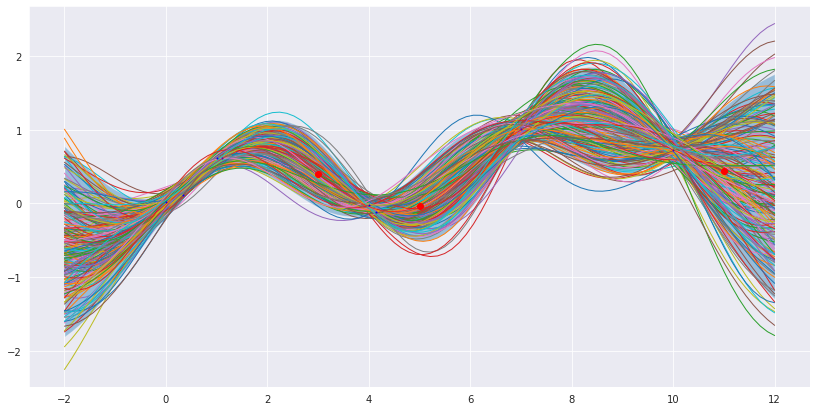

In [118]:
pointwise_variances = f_post_covar.diagonal()
error = 1.96 * np.sqrt(pointwise_variances)

# plot
fig, ax = plt.subplots(figsize=(14, 7))
if f_post_samples is not None:
    ax.plot(X_post, f_post_samples, ms=2, lw=1)
ax.plot(X_train.ravel(), y_train.ravel(), 'b.', ms=2)
ax.plot(X_post.ravel(), f_post_mean.ravel(), 'r-', ms=1, lw=.5)
ax.fill_between(X_post.ravel(), f_post_mean.ravel()-error, f_post_mean.ravel()+error, alpha=.4)
ax.plot(X_test.ravel(), f_star_mean.ravel(), 'r.', ms=12)
#ax.plot(X_train, y_train, 'r+', ms=6)
#ax.plot(X_test, f1(X_test), 'r-', lw=.1)
plt.show()
#

In [119]:
f_post_samples.shape

(100, 200)

In [121]:
np.savetxt(fname="samples.csv", X=f_post_samples, fmt='%f', delimiter = ";")

# Kernels

In [10]:
class WhiteNoise():
    def __init__(self, signal_variance=1.0, signal_variance_bounds=(1e-5, 1e5)):
        self.theta = [signal_variance]
        self.bounds = [signal_variance_bounds]
    def __call__(self, X1, X2=None):
        if X2 is None:
            K = self.theta[0] * np.dot(X1, X1.T)
        else:
            K = self.theta[0] * np.dot(X1, X2.T)
        return K

class Linear():
    def __init__(self, signal_variance=1.0, signal_variance_bounds=(1e-5, 1e5)):
        self.theta = [signal_variance]
        self.bounds = [signal_variance_bounds]
    def __call__(self, X1, X2=None):
        if X2 is None:
            K = self.theta[0] * np.dot(X1, X1.T)
        else:
            K = self.theta[0] * np.dot(X1, X2.T)
        return K
    

class SquaredExponential():
    def __init__(self, length_scale=1.0, sigma=1.0, length_scale_bounds=(1e-5, 1e5)):
        self.theta = [length_scale, sigma]
        self.bounds = [length_scale_bounds]
    def __call__(self, X1, X2=None):
        if X2 is None:
            # K(X1, X1) is symmetric so avoid redundant computation using pdist.
            dists = pdist(X1 / self.theta[0], metric='sqeuclidean')
            K = np.exp(-0.5 * dists)
            K = squareform(K)
            np.fill_diagonal(K, 1)
        else:
            dists = cdist(X1 / self.theta[0], X2 / self.theta[0], metric='sqeuclidean')
            K = np.exp(-0.5 * dists)
            
        return self.theta[1]*K


class RationalQuadratic():
    def __init__(self, length_scale=1.0, alpha=1.0, sigma=1.0, length_scale_bounds=(1e-5, 1e5), alpha_bounds=(1e-5,1e5)):
        self.theta = [length_scale, alpha, sigma]
        self.bounds = [length_scale_bounds, alpha_bounds]
    def __call__(self, X1, X2=None):
        if X2 is None:
            # K(X1, X1) is symmetric so avoid redundant computation using pdist.
            dists = pdist(X1 / self.theta[0]*np.sqrt(self.theta[1]), metric='sqeuclidean')
            K = (1 + dists)**(-self.theta[1])
            K = squareform(K)
            np.fill_diagonal(K, 1)
        else:
            dists = cdist(X1 / self.theta[0]*np.sqrt(self.theta[1]), X2 / self.theta[0]*np.sqrt(self.theta[1]), metric='sqeuclidean')
            K = (1 + dists)**(-self.theta[1])
        return self.theta[2]*K
    

class Periodic():
    def __init__(self, length_scale=1.0, period=1.0, sigma=1.0, frequency_bounds=(1e-5, 1e5)):
        self.theta = [length_scale, period, sigma]
        self.bounds = [frequency_bounds]
    def __call__(self, X1, X2=None):
        if X2 is None:
            # K(X1, X1) is symmetric so avoid redundant computation using pdist.
            dists = pdist(X1, lambda xi, xj: np.dot(np.sin(np.pi * (xi - xj)/self.theta[1]).T/self.theta[1], 
                np.sin(np.pi * (xi - xj)/self.theta[1]))/self.theta[0])
            K = np.exp(-2*dists)
            K = squareform(K)
            np.fill_diagonal(K, 1)
        else:
            dists = cdist(X1, X2, lambda xi, xj: np.dot(np.sin(np.pi * (xi - xj)/self.theta[1]).T/self.theta[0], 
                np.sin(np.pi * (xi - xj)/self.theta[1]))/self.theta[0])
            K = np.exp(-2*dists)
        return self.theta[2]*K
    
#class Matern():
#    def __init__(self, length_scale=1.0, frequency=1.0, frequency_bounds=(1e-5, 1e5)):
#        self.theta = [length_scale, frequency]
#        self.bounds = [frequency_bounds]
#    def __call__(self, X1, X2=None):
#        if X2 is None:
#            # K(X1, X1) is symmetric so avoid redundant computation using pdist.
#            dists = pdist(X1, lambda xi, xj: np.dot(np.sin(np.pi * (xi - xj)/self.theta[1]).T/self.theta[1], 
#                np.sin(np.pi * (xi - xj)/self.theta[1]))/self.theta[0])
#            K = np.exp(-2*dists)
#            K = squareform(K)
#            np.fill_diagonal(K, 1)
#        else:
#            dists = cdist(X1, X2, lambda xi, xj: np.dot(np.sin(np.pi * (xi - xj)/self.theta[1]).T/self.theta[0], 
#                np.sin(np.pi * (xi - xj)/self.theta[1]))/self.theta[0])
#            K = np.exp(-2*dists)
#        return K


